# Give Me Some Credit

In [142]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
%matplotlib inline

In [20]:
random_state = 1

# Charger les données

In [21]:
data = pd.read_csv('data/cs-training.csv').drop('Unnamed: 0', axis = 1)

In [22]:
X = data.drop('SeriousDlqin2yrs', axis=1)
y = data.SeriousDlqin2yrs

On fait un premier nettoyage des données qui consiste à remplacer les blancs par des médianes.

In [ ]:
feature_names = np.array(X.columns)
X.loc[X.MonthlyIncome.isnull(), 'MonthlyIncome'] = X.MonthlyIncome.median()
X.loc[X.NumberOfDependents.isnull(), 'NumberOfDependents'] = X.NumberOfDependents.median()

In [23]:
X.describe()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,1.500000e+05,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,6.048438,52.295207,0.421033,353.005076,6.418455e+03,8.452760,0.265973,1.018240,0.240387,0.737413
std,249.755371,14.771866,4.192781,2037.818523,1.289040e+04,5.145951,4.169304,1.129771,4.155179,1.107021
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.029867,41.000000,0.000000,0.175074,3.903000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.559046,63.000000,0.000000,0.868254,7.400000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


# Essai de plusieurs modèles simples

In [33]:
from sklearn.metrics import roc_curve, auc

In [34]:
clfs = {
    'RandomForestClassifier': RandomForestClassifier(n_estimators=10, random_state=random_state),
    'LogisticRegression': LogisticRegression(solver='lbfgs', random_state=random_state),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=random_state),
    'ExtraTreesClassifier': ExtraTreesClassifier(random_state=random_state),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(3),
    'DecisionTreeClassifier': DecisionTreeClassifier(max_depth=5),
    'GaussianNB': GaussianNB()
}

In [35]:
def fit_and_score_clfs(clfs, X=X, y=y, test_size=0.9):
    '''
        Given a dict of classifiers, return a dict of scores obtained by fitting each classifier
        on the set (X, y) with the given test_proportion

        clfs: dict of classifiers
                key: name of clf
                value: clf object
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    scores = dict()
    for name, clf in clfs.items():
        clf.fit(X_train, y_train)
        scores[name] = clf.score(X_test, y_test)

    return scores

In [36]:
# fit_and_score_clfs(clfs)

In [37]:
def eval_model(mod, X, y, name=None, CVNFOLDS=7):
    cv = StratifiedKFold(n_splits=CVNFOLDS)
    mem = []
    for i, (training, test) in enumerate(cv.split(X, y)):
        fit = mod.fit(X.iloc[training], y.iloc[training])
        prob = fit.predict_proba(X.iloc[test])
        fpr, tpr, _ = roc_curve(y.iloc[test], prob[:, 1])
        a = auc(fpr, tpr)
        mem.append(a)
        #print('ROC: %f' % a)
        plt.plot(fpr, tpr)
    plt.xlabel('False Positive Ratio')
    plt.ylabel('True Positive Ratio')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.title(name)
    plt.show()
    print("Mean: %f" % np.mean(mem))

In [38]:
#for name, clf in clfs.items():
    #eval_model(clf, X, y, name=name)


# Visualisation des données

In [43]:
def visualization():
    # # B/M plot
    plt.barh(['no problem', 'seriousProblemIn2Years'], [np.sum(y == 1), np.sum(y == 0)])
    plt.xlabel('Nombre d\'entrées')
    plt.show()

    # Violin plot
    data_melt = data.melt(id_vars=['SeriousDlqin2yrs'])
    sns.violinplot(x='variable', y='value', hue='SeriousDlqin2yrs',
               split=True, inner="quart",
               scale='area',
               data=data_melt)
    sns.despine(left=True)
    plt.xticks(rotation=90)
    plt.xlabel('')
    plt.show()

    # Correlation
    # Compute the correlation matrix
    corr = X.corr()

    # # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # # Draw the heatmap with the mask and correct aspect ratio
    f, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(corr, mask=mask, annot=True, fmt=".1f", linewidths=.7)
    plt.show()

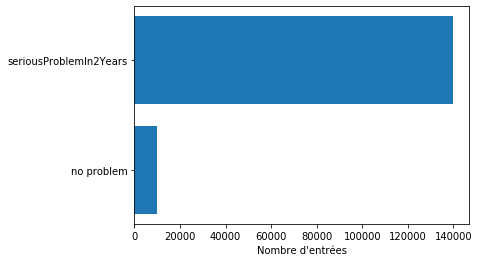

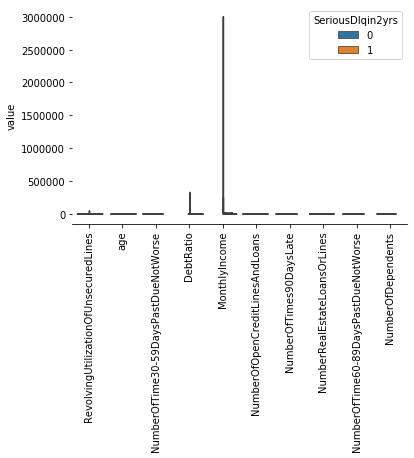

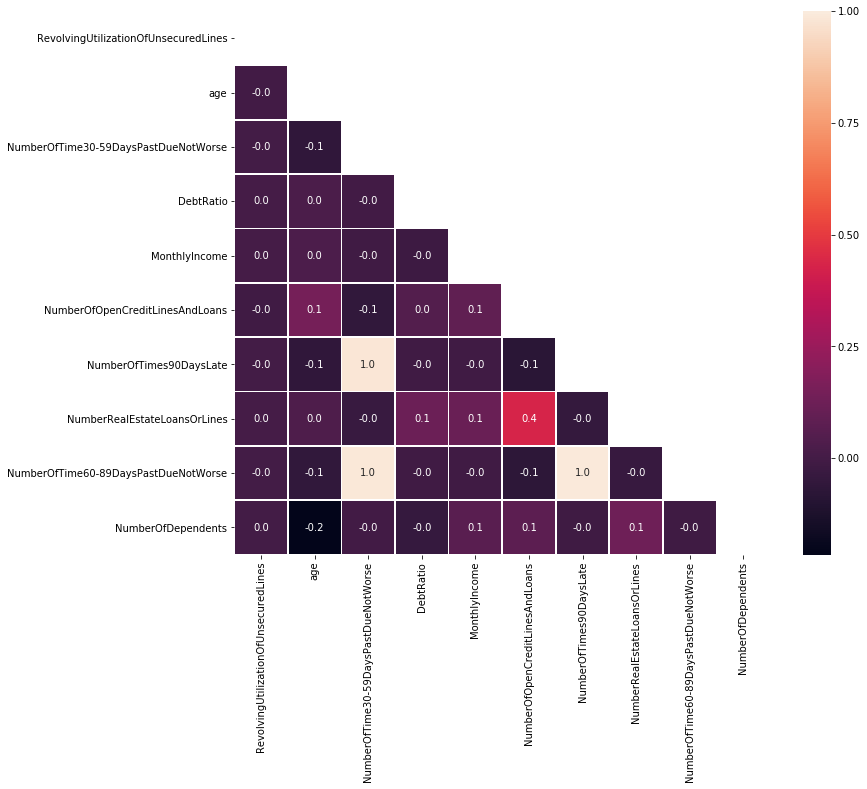

In [44]:
visualization()

On remarque que les features sont très décorrélées. Ceci implique qu'une PCA a peu de chance de donner des résultats de qualité équivalente pour un temps de training moins long. Pour s'en convaincre, traçons le diagramme d'éboulis :

In [163]:
def find_optimal_dimension(data, explained_proportion, show=False):
    '''
        Return how many dimensions to keep to explain a given proportion of the data.
        Informative purpose only since this feature is already implemented in sklearn.
        Use PCA(n_components=explained_proportion) instead.

        data : array of shape (n_samples, n_features)
        explained_proportion : float in [0, 1]
    '''
    p = data.shape[1] - 1
    pca = PCA(data.shape[1])

    # Important : Normalize data to have homogenous features
    pipeline = Pipeline([('scaling', StandardScaler()), ('pca', pca)])
    data = pipeline.fit_transform(data)

    # Determine how many components to keep
    explained_ratio = np.cumsum(pca.explained_variance_ratio_)
    for k in range(len(explained_ratio)):
        if explained_ratio[k] >= explained_proportion:
            p=k+1
            break
    print('Keeping {} components to explain {}% of the variance'.format(p, 100*explained_proportion))

    if show:
        eigen_values = pca.explained_variance_
        plt.plot(range(len(eigen_values)), eigen_values)
        plt.axvline(p, c='orange')
        plt.xlabel('Eigenvalue index')
        plt.ylabel('Eigenvalue')
        plt.title('Keeping {} components to explain {}% of the variance'.format(p, 100*explained_proportion))
        plt.show()        

    return p

Keeping 10 components to explain 95.0% of the variance


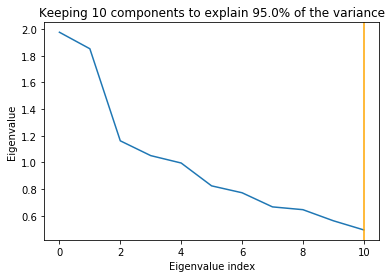

10

In [165]:
find_optimal_dimension(data, .95, show=True)

# Nettoyage des données

In [49]:
from collections import Counter

On reprend un jeu de données propre :

In [97]:
data = pd.read_csv('data/cs-training.csv').drop('Unnamed: 0', axis = 1)

### Age

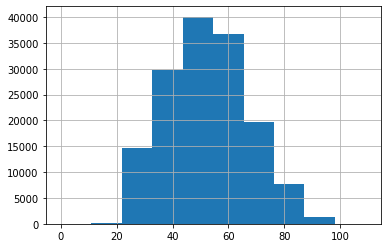

In [98]:
data.age.hist()

In [99]:
Counter(data[data.age<30].age)

Counter({27: 1338,
         25: 953,
         24: 816,
         28: 1560,
         26: 1193,
         29: 1702,
         23: 641,
         22: 434,
         21: 183,
         0: 1})

Une personne est agée de 0 an, c'est probablement une erreur. On le remplace par la médiane.

In [100]:
data.loc[data.age < 21, 'age'] = data.age.median()

In [101]:
Counter(data[data.age>100].age)

Counter({101.0: 3, 103.0: 3, 102.0: 3, 107.0: 1, 105.0: 1, 109.0: 2})

### NumberOfTime30-59DaysPastDueNotWorse

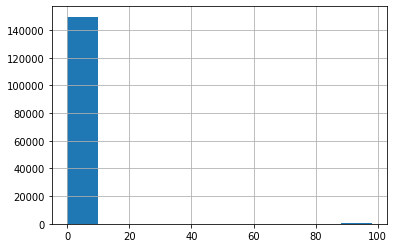

In [102]:
data["NumberOfTime30-59DaysPastDueNotWorse"].hist()

In [103]:
Counter(data["NumberOfTime30-59DaysPastDueNotWorse"])

Counter({2: 4598,
         0: 126018,
         1: 16033,
         3: 1754,
         4: 747,
         5: 342,
         7: 54,
         10: 4,
         6: 140,
         98: 264,
         12: 2,
         8: 25,
         9: 12,
         96: 5,
         13: 1,
         11: 1})

On suppose que les valeurs 98 et 96 sont des erreurs.

In [104]:
data.loc[
    data["NumberOfTime30-59DaysPastDueNotWorse"] > 20,
    'NumberOfTime30-59DaysPastDueNotWorse',
] = data["NumberOfTime30-59DaysPastDueNotWorse"].median()

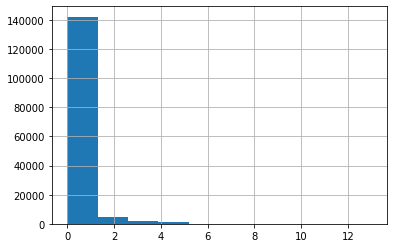

In [105]:
data["NumberOfTime30-59DaysPastDueNotWorse"].hist()

### NumberOfTimes90DaysLate

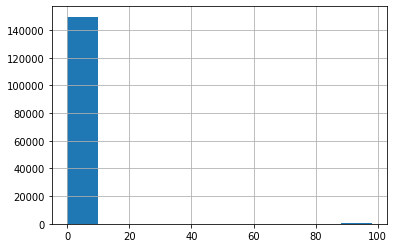

In [106]:
data.NumberOfTimes90DaysLate.hist()

In [107]:
Counter(data.NumberOfTimes90DaysLate)

Counter({0: 141662,
         1: 5243,
         3: 667,
         2: 1555,
         5: 131,
         4: 291,
         98: 264,
         10: 8,
         9: 19,
         6: 80,
         7: 38,
         8: 21,
         15: 2,
         96: 5,
         11: 5,
         13: 4,
         14: 2,
         17: 1,
         12: 2})

On suppose encore que les valeurs 96 et 98 sont des erreurs.

In [108]:
data.loc[
    data.NumberOfTimes90DaysLate > 20,
    'NumberOfTimes90DaysLate',
] = data.NumberOfTimes90DaysLate.median()

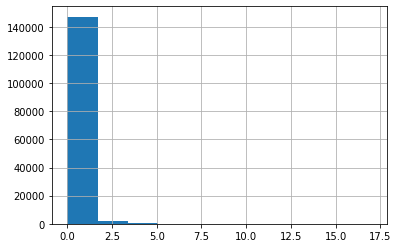

In [109]:
data.NumberOfTimes90DaysLate.hist()

### NumberRealEstateLoansOrLines¶

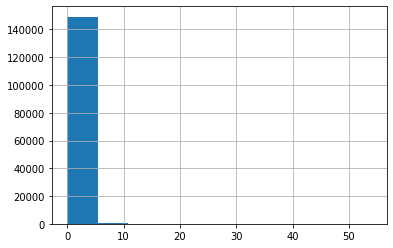

In [110]:
data.NumberRealEstateLoansOrLines.hist()

In [111]:
Counter(data.NumberRealEstateLoansOrLines)

Counter({6: 320,
         0: 56188,
         1: 52338,
         3: 6300,
         4: 2170,
         2: 31522,
         5: 689,
         8: 93,
         7: 171,
         9: 78,
         17: 4,
         15: 7,
         10: 37,
         12: 18,
         11: 23,
         16: 4,
         26: 1,
         14: 7,
         54: 1,
         21: 1,
         18: 2,
         13: 15,
         23: 2,
         29: 1,
         25: 3,
         19: 2,
         20: 2,
         32: 1})

Ici, les valeurs ne sont pas aussi dispersées que dans les cas précédents. Nous considérons qu'elles sont sans erreurs.

### NumberOfDependents

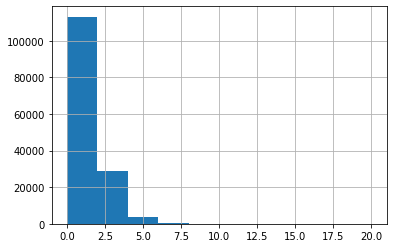

In [112]:
data.NumberOfDependents.hist()

In [113]:
Counter(data.NumberOfDependents)

Counter({2.0: 19522,
         1.0: 26316,
         0.0: 86902,
         nan: 1,
         3.0: 9483,
         nan: 1,
         nan: 1,
         4.0: 2862,
         5.0: 746,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         6.0: 158,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         8.0: 24,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
        

On retrouve beaucoup de valeurs NaN. On les remplace par la médiane.

In [114]:
data.loc[
    data.NumberOfDependents.isnull(),
    'NumberOfDependents',
] = data.NumberOfDependents.median()

In [115]:
data.NumberOfDependents[data.NumberOfDependents.isnull()]

Series([], Name: NumberOfDependents, dtype: float64)

In [116]:
Counter(data.NumberOfDependents)

Counter({2.0: 19522,
         1.0: 26316,
         0.0: 90826,
         3.0: 9483,
         4.0: 2862,
         5.0: 746,
         6.0: 158,
         8.0: 24,
         7.0: 51,
         20.0: 1,
         10.0: 5,
         9.0: 5,
         13.0: 1})

Les valeurs supérieures à 10 sont probablement des erreurs car très rares.

In [117]:
data.loc[
    data.NumberOfDependents > 10,
    'NumberOfDependents',
] = 10

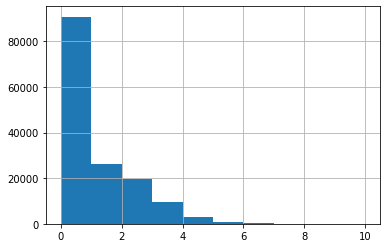

In [118]:
data.NumberOfDependents.hist()

### RevolvingUtilizationOfUnsecuredLines

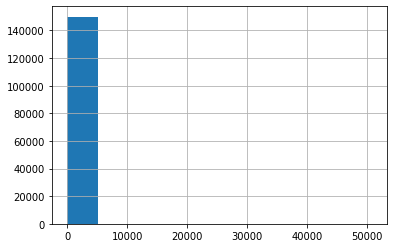

In [119]:
data.RevolvingUtilizationOfUnsecuredLines.hist()

In [120]:
data.loc[
    data.RevolvingUtilizationOfUnsecuredLines > 5,
    'RevolvingUtilizationOfUnsecuredLines',
] = data.RevolvingUtilizationOfUnsecuredLines.median()

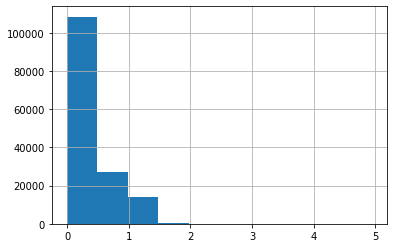

In [121]:
data.RevolvingUtilizationOfUnsecuredLines.hist()

### DebtRatio

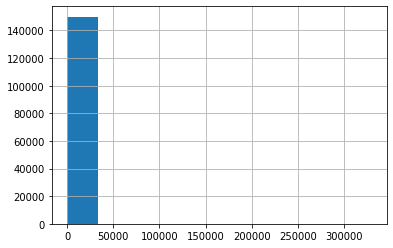

In [122]:
data.DebtRatio.hist()

In [123]:
Counter(data.DebtRatio)

Counter({0.8029821290000001: 1,
         0.12187620099999999: 1,
         0.085113375: 1,
         0.036049682: 2,
         0.024925695: 1,
         0.375606969: 1,
         5710.0: 1,
         0.20994001699999998: 3,
         46.0: 35,
         0.606290901: 1,
         0.30947621: 1,
         0.53152876: 1,
         0.298354075: 1,
         0.38296474700000005: 1,
         477.0: 7,
         0.20989175399999999: 1,
         2058.0: 11,
         0.18827406: 1,
         0.527887839: 1,
         0.065868263: 1,
         0.430046338: 1,
         0.47584138600000003: 1,
         0.241103559: 3,
         0.085512189: 1,
         0.241621845: 1,
         1.595253368: 1,
         0.097672186: 1,
         0.042383047: 2,
         0.011761246999999999: 2,
         0.436102527: 1,
         0.155201143: 1,
         0.472703063: 1,
         977.0: 7,
         0.313812313: 1,
         0.257731959: 2,
         0.073538769: 1,
         0.567858035: 2,
         0.134078212: 2,
         0.00999001: 1,


In [124]:
data.loc[
    data.DebtRatio > 1,
    'DebtRatio',
] = data.DebtRatio.median()

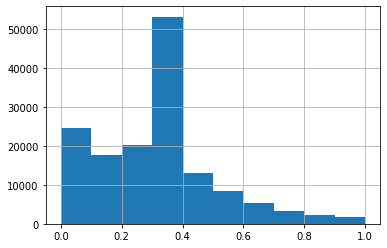

In [125]:
data.DebtRatio.hist()

In [126]:
data.DebtRatio.describe()

count    150000.000000
mean          0.317893
std           0.199835
min           0.000000
25%           0.175074
50%           0.366506
75%           0.380021
max           1.000000
Name: DebtRatio, dtype: float64

### MonthlyIncome

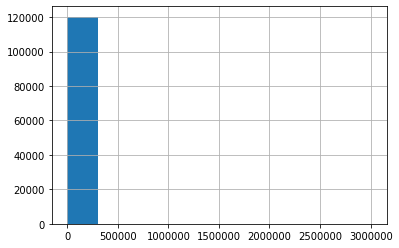

In [127]:
data.MonthlyIncome.hist()

In [128]:
data.MonthlyIncome.describe()

count    1.202690e+05
mean     6.670221e+03
std      1.438467e+04
min      0.000000e+00
25%      3.400000e+03
50%      5.400000e+03
75%      8.249000e+03
max      3.008750e+06
Name: MonthlyIncome, dtype: float64

In [129]:
data.loc[data.MonthlyIncome.isnull(), 'MonthlyIncome'] = data.MonthlyIncome.median()

In [130]:
data.MonthlyIncome.describe()

count    1.500000e+05
mean     6.418455e+03
std      1.289040e+04
min      0.000000e+00
25%      3.903000e+03
50%      5.400000e+03
75%      7.400000e+03
max      3.008750e+06
Name: MonthlyIncome, dtype: float64

### NumberOfOpenCreditLinesAndLoans

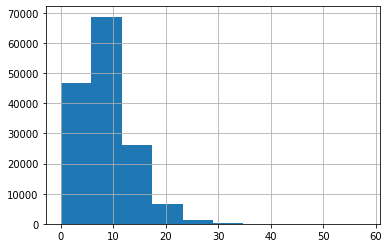

In [131]:
data.NumberOfOpenCreditLinesAndLoans.hist()

In [132]:
data.NumberOfOpenCreditLinesAndLoans.describe()

count    150000.000000
mean          8.452760
std           5.145951
min           0.000000
25%           5.000000
50%           8.000000
75%          11.000000
max          58.000000
Name: NumberOfOpenCreditLinesAndLoans, dtype: float64

Il ne semble pas y avoir d'erreurs manifestes.

### NumberOfTime60-89DaysPastDueNotWorse

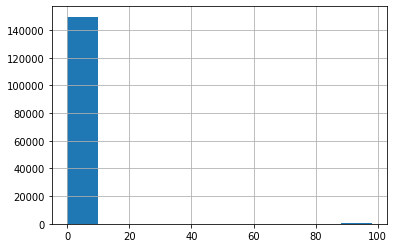

In [133]:
data["NumberOfTime60-89DaysPastDueNotWorse"].hist()

In [134]:
data["NumberOfTime60-89DaysPastDueNotWorse"].describe()

count    150000.000000
mean          0.240387
std           4.155179
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          98.000000
Name: NumberOfTime60-89DaysPastDueNotWorse, dtype: float64

## Vérifications

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11f2f18d0>,
      dtype=object)

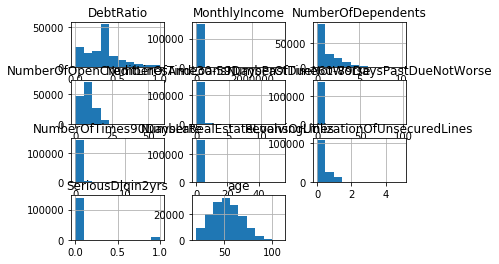

In [135]:
data.hist()

## Nouvel essai d'entrainement de modèles

In [136]:
X = data.drop('SeriousDlqin2yrs', axis=1)
y = data.SeriousDlqin2yrs

/Users/antoine/Documents/Ponts/2A/MALAP/RAPPEL/GiveMeSomeCredit/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


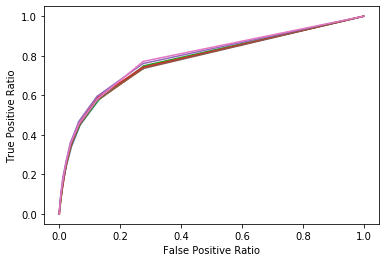

Mean: 0.783140


In [137]:
eval_model(RandomForestClassifier(), X, y)

/Users/antoine/Documents/Ponts/2A/MALAP/RAPPEL/GiveMeSomeCredit/venv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/antoine/Documents/Ponts/2A/MALAP/RAPPEL/GiveMeSomeCredit/venv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/antoine/Documents/Ponts/2A/MALAP/RAPPEL/GiveMeSomeCredit/venv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/antoine/Documents/Ponts/2A/MALAP/RAPPEL/GiveMeSomeCredit/venv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

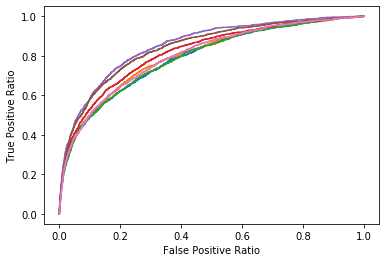

Mean: 0.812969


In [138]:
eval_model(LogisticRegression(), X, y)

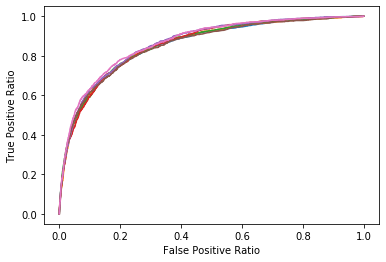

Mean: 0.858762


In [139]:
eval_model(AdaBoostClassifier(), X, y)

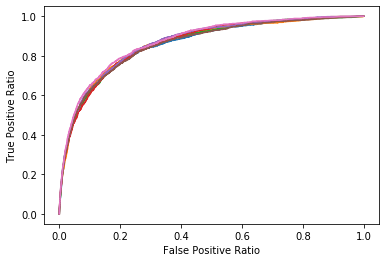

Mean: 0.863564


In [140]:
eval_model(GradientBoostingClassifier(), X, y)

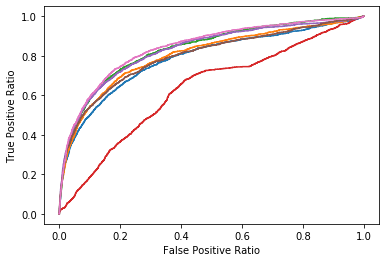

Mean: 0.788042


In [143]:
eval_model(MLPClassifier(), X, y)

On remarque une amélioration des modèles, en particulier sur la régression logistique où la différence de qualité de prédiction est tout à fait étonnante. Les résultats donnés par MLP sont mauvais, probablement parce que ce modèle demande un choix d'hyper-paramètres soignés.

## Optimisation du GradientBoostingClassifier

On utilise Grid Search pour déterminer les meilleurs hyper parametres. Nous allons essayer d'optimiser sur les paramètres suivants :
- n_estimators
- max_depth
- min_samples_split

### n_estimator

In [145]:
from sklearn.model_selection import GridSearchCV

In [147]:
parameters = {'n_estimators': range(50,301,50)}
# parameters = {'n_estimators': range(300,701,100)}
# parameters = {'n_estimators': range(250,350,25)}
# parameters = {'n_estimators': range(260,290,5)}

gs = GridSearchCV(GradientBoostingClassifier(), parameters, scoring='roc_auc')
gs.fit(X, y)
print(gs.best_params_, gs.best_score_)

/Users/antoine/Documents/Ponts/2A/MALAP/RAPPEL/GiveMeSomeCredit/venv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'n_estimators': 250} 0.8638231561975044


### max_depth

In [148]:
parameters = {'max_depth': range(2,5,1)}
gs = GridSearchCV(GradientBoostingClassifier(
    n_estimators=270,
), parameters, scoring='roc_auc')
gs.fit(X, y)
print(gs.best_params_, gs.best_score_)

/Users/antoine/Documents/Ponts/2A/MALAP/RAPPEL/GiveMeSomeCredit/venv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_depth': 3} 0.8638176409388229


### min_samples_split

In [150]:
parameters = {'min_samples_split': range(2,4,1)}
gs = GridSearchCV(GradientBoostingClassifier(
    n_estimators=270,
    max_depth=3,
), parameters, scoring='roc_auc')
gs.fit(X, y)
print(gs.best_params_, gs.best_score_)

/Users/antoine/Documents/Ponts/2A/MALAP/RAPPEL/GiveMeSomeCredit/venv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'min_samples_split': 3} 0.8638787694580571


### Evaluation

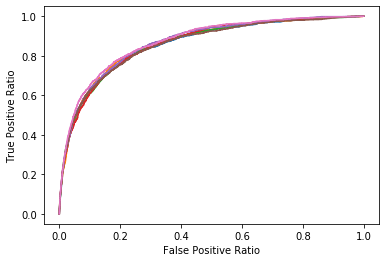

Mean: 0.863520


In [168]:
clf = GradientBoostingClassifier(
    n_estimators=270,
    max_depth=3,
    min_samples_split=0.8638787694580571,
)
eval_model(clf, X, y)

## Utilisation d'un modèle pour nettoyer les données 

Pour le moment, le défaut majeur de notre travail repose sur notre choix de valeurs pour remplacer les données fausses/abérantes.

In [169]:
def plot_feature_importance(clf, X_train, y_train, feature_names=feature_names):
    '''
        Given a classifier clf and a fitting set (X, y), fit the clf 
        and plot the importance of each feature.
        
        clf: classifier with feature_importances_ attribute. 
    '''
    clf.fit(X, y)
    feature_importance = dict(zip(feature_names, clf.feature_importances_))
    sorted_feature_importance = np.array(sorted(feature_importance.items(), key=lambda x: x[1]))

    plt.barh(sorted_feature_importance[:, 0], sorted_feature_importance[:, 1].astype(float))
    plt.xlabel('Feature importance')
    plt.show()

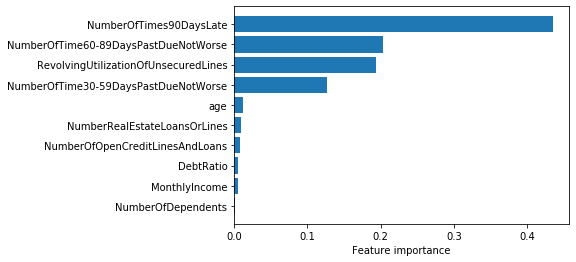

In [171]:
X_train, y_train, _, _ = train_test_split(X, y, test_size=0.9, random_state=random_state)
plot_feature_importance(clf, X_train, y_train)

Nous proposons désormais un modèle de prédiction de la feature `NumberOfTimes90DaysLate` grâce aux autres features lorsque celle-ci semble erronée.